In [63]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from vgg16 import VGG16
import pickle
from tqdm import tqdm
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Merge, Activation, Flatten
from keras.optimizers import Adam

In [64]:
token = 'Flickr8k_text/Flickr8k.token.txt'

In [65]:
captions = open(token, 'r').read().strip().split('\n')

## Creating a dictionary containing all the captions of the images

In [66]:
d = {}
for i, row in enumerate(captions):
    row = row.split('\t')
    row[0] = row[0][:len(row[0])-2]
    if row[0] in d:
        d[row[0]].append(row[1])
    else:
        d[row[0]] = [row[1]]

In [67]:
d['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [68]:
images = 'Flickr8k_Dataset/Flicker8k_Dataset/'

In [69]:
# Contains all the images
img = glob.glob(images+'*.jpg')

In [70]:
img[:5]

['Flickr8k_Dataset/Flicker8k_Dataset/17273391_55cfc7d3d4.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/2890075175_4bd32b201a.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/3356642567_f1d92cb81b.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/186890605_ddff5b694e.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/2773682293_3b712e47ff.jpg']

In [71]:
train_images_file = 'Flickr8k_text/Flickr_8k.trainImages.txt'

In [72]:
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

In [73]:
def split_data(l):
    temp = []
    for i in img:
        if i[len(images):] in l:
            temp.append(i)
    return temp

In [74]:
# Getting the training images from all the images
train_img = split_data(train_images)
len(train_img)

6000

In [75]:
val_images_file = 'Flickr8k_text/Flickr_8k.devImages.txt'
val_images = set(open(val_images_file, 'r').read().strip().split('\n'))

In [76]:
# Getting the validation images from all the images
val_img = split_data(val_images)
len(val_img)

1000

In [77]:
test_images_file = 'Flickr8k_text/Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

In [78]:
# Getting the testing images from all the images
test_img = split_data(test_images)
len(test_img)

1000

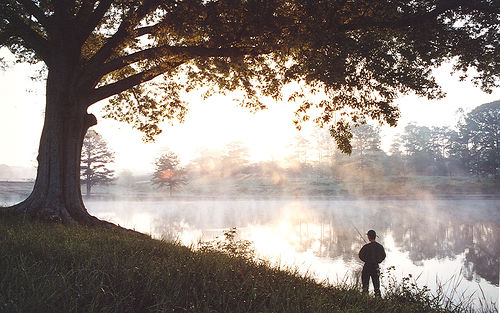

In [79]:
Image.open(train_img[0])

We will feed these images to VGG-16 to get the encoded images. Hence we need to preprocess the images as the authors of VGG-16 did. The last layer of VGG-16 is the softmax classifier(FC layer with 1000 hidden neurons) which returns the probability of a class. This layer should be removed so as to get a feature representation of an image. We will use the last Dense layer(4096 hidden neurons) after popping the classifier layer. Hence the shape of the encoded image will be (1, 4096)

In [80]:
def subtract_mean(img):
    mean_sub = np.array([123.68, 116.779, 103.939], dtype=np.float32)
    return (img - mean_sub)[:,:,:,::-1]

In [81]:
def preprocess(image):
    img = Image.open(image)
    img = img.resize((224,224), Image.NEAREST)
    img = np.array(img)
    img = np.expand_dims(img, 0)
    img = subtract_mean(img)
    return img

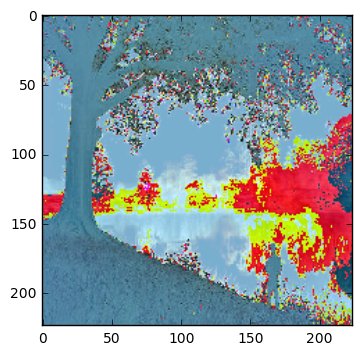

In [82]:
plt.imshow(np.squeeze(preprocess(train_img[0])))

In [83]:
model = VGG16()
model.load_weights('vgg16_tf.h5')

In [84]:
model.pop()
model.pop()
model.trainable = False
for i in model.layers:
    i.trainable = False

In [85]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
zeropadding2d_1 (ZeroPadding2D)  (None, 226, 226, 3)   0           zeropadding2d_input_1[0][0]      
____________________________________________________________________________________________________
conv1_1 (Convolution2D)          (None, 224, 224, 64)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 226, 226, 64)  0           conv1_1[0][0]                    
____________________________________________________________________________________________________
conv1_2 (Convolution2D)          (None, 224, 224, 64)  36928       zeropadding2d_2[0][0]            
___________________________________________________________________________________________

In [86]:
tryi = model.predict(preprocess(train_img[0]))

In [87]:
tryi.shape

(1, 4096)

In [83]:
def encode(image):
    image = preprocess(image)
    temp_enc = model.predict(image)
    temp_enc = np.reshape(temp_enc, temp_enc.shape[1])
    return temp_enc

In [23]:
# Encoding the training images using VGG-16
encoding_train = {}
for img in tqdm(train_img):
    encoding_train[img[len(images):]] = encode(img)

In [36]:
with open("encoded_images.p", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle) 

In [41]:
encoding_train['3556792157_d09d42bef7.jpg'].shape

(4096,)

In [84]:
encoding_train = pickle.load(open('encoded_images.p', 'rb'))

In [99]:
# Encoding the test images using VGG-16
encoding_test = {}
for img in tqdm(test_img):
    encoding_test[img[len(images):]] = encode(img)

100%|██████████| 1000/1000 [18:50<00:00,  1.10s/it]


In [100]:
with open("encoded_images_test.p", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle) 

In [85]:
encoding_test = pickle.load(open('encoded_images_test.p', 'rb'))

In [86]:
encoding_test[test_img[0][len(images):]].shape

(4096,)

In [87]:
train_d = {}
for i in train_img:
    if i[len(images):] in d:
        train_d[i] = d[i[len(images):]]

In [88]:
len(train_d)

6000

In [89]:
train_d[images+'3556792157_d09d42bef7.jpg']

['A bunch of children sitting in chairs and standing on wooden floors .',
 'A group of children sit , stand , and kneel along a wall .',
 'A group of children sitting on folding chairs and playing .',
 'a young group of children sitting in a row against the wall .',
 'The kids talking while sitting on a row of chairs along the wall .']

In [90]:
with open("training_images_captions.p", "wb") as pickle_d:
    pickle.dump(train_d, pickle_d)

In [91]:
val_d = {}
for i in val_img:
    if i[len(images):] in d:
        val_d[i] = d[i[len(images):]]

In [92]:
len(val_d)

1000

In [93]:
with open("validation_images_captions.p", "wb") as pickle_d:
    pickle.dump(val_d, pickle_d) 

In [94]:
test_d = {}
for i in test_img:
    if i[len(images):] in d:
        test_d[i] = d[i[len(images):]]

In [95]:
len(test_d)

1000

In [96]:
with open("test_images_captions.p", "wb") as pickle_d:
    pickle.dump(test_d, pickle_d) 

Calculating the unique words in the vocabulary.

In [97]:
caps = []
for key, val in d.items():
    for i in val:
        caps.append(i)

In [98]:
words = [i.split() for i in caps]

In [99]:
unique = []
for i in words:
    unique.extend(i)

In [100]:
unique.extend("<start>".split())
unique.extend("<end>".split())

In [101]:
unique = list(set(unique))

In [102]:
len(unique)

9632

Mapping the unique words to indices and vice-versa

In [103]:
word2idx = {val:index for index, val in enumerate(unique)}

In [104]:
word2idx['<start>']

5721

In [105]:
idx2word = {index:val for index, val in enumerate(unique)}

In [107]:
idx2word[5721]

'<start>'

Calculating the maximum length among all the captions

In [108]:
max_len = 0
for c in caps:
    c = c.split()
    if len(c) > max_len:
        max_len = len(c)
max_len

38

In [109]:
len(unique), max_len

(9632, 38)

In [110]:
vocab_size = len(unique)

In [111]:
vocab_size

9632

Adding <start> and <end> to all the captions to indicate the starting and ending of a sentence. This will be used while we predict the caption of an image

In [135]:
f = open('flickr8k_training_dataset.txt', 'w')
f.write("image_id\tcaptions\n")

18

In [136]:
for key, val in train_d.items():
    for i in val:
        f.write(key[len(images):] + "\t" + "<start> " + i +" <end>" + "\n")

f.close()

In [112]:
df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')

In [113]:
len(df)

30000

In [114]:
c = [i for i in df['captions']]

In [115]:
imgs = [i for i in df['image_id']]

In [116]:
a = c[0]
a

'<start> A basketball player wearing an orange uniform looks backwards . <end>'

In [117]:
for i in a.split():
    print (i, "=>", word2idx[i])

<start> => 5721
A => 5778
basketball => 9546
player => 8243
wearing => 6495
an => 1196
orange => 748
uniform => 1018
looks => 985
backwards => 841
. => 6709
<end> => 8632


In [118]:
samples_per_epoch = 0
for ca in caps:
    ca = "<start> " + ca + " <end>"
    samples_per_epoch += len(ca.split())-1

In [119]:
samples_per_epoch

517166

## Generator 

We will use the encoding of an image and use a start word to predict the next word.
After that, we will again use the same image and use the start word and the predicted word 
to predict the next word.
So, the image will be used at every iteration for the entire caption. 
This is how we will generate the caption for an image. Hence, we need to create 
a custom generator for that.

The CS231n lecture by Andrej Karpathy explains this concept very clearly and beautifully.
Link for the lecture:- https://youtu.be/cO0a0QYmFm8?t=32m25s

In [120]:
def data_generator(batch_size=32):
    partial_caps = []
    next_words = []
    images = []
    count = 0
    for i, text in enumerate(c):
        current_image = encoding_train[imgs[i]]
        for j in range(len(text.split())-1):
            count+=1
            partial = [word2idx[t] for t in text.split()[:j+1]]
            partial_caps.append(partial)
            # Initializing with zeros to create a one-hot encoding matrix
            # This is what we have to predict
            # Hence initializing it with vocab_size length
            next = np.zeros(vocab_size)
            # Setting the next word to 1
            next[word2idx[text.split()[j+1]]] = 1
            next_words.append(next)
            images.append(current_image)
            
            if count >= batch_size:
                images = np.array(images)
                next_words = np.array(next_words)
                partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                yield [[images, partial_caps], next_words]
                partial_caps = []
                images = []
                next_words = []
                count = 0

In [121]:
for i, val in enumerate(data_generator()):
    if i==0:
        print (val)

[[array([[ 0.        ,  1.15606487,  0.        , ...,  0.        ,
         0.        ,  3.6591897 ],
       [ 0.        ,  1.15606487,  0.        , ...,  0.        ,
         0.        ,  3.6591897 ],
       [ 0.        ,  1.15606487,  0.        , ...,  0.        ,
         0.        ,  3.6591897 ],
       ..., 
       [ 0.        ,  1.15606487,  0.        , ...,  0.        ,
         0.        ,  3.6591897 ],
       [ 0.        ,  1.15606487,  0.        , ...,  0.        ,
         0.        ,  3.6591897 ],
       [ 0.        ,  1.15606487,  0.        , ...,  0.        ,
         0.        ,  3.6591897 ]], dtype=float32), array([[5721,    0,    0, ...,    0,    0,    0],
       [5721, 5778,    0, ...,    0,    0,    0],
       [5721, 5778, 9546, ...,    0,    0,    0],
       ..., 
       [5721, 4376, 9546, ...,    0,    0,    0],
       [5721,    0,    0, ...,    0,    0,    0],
       [5721, 4376,    0, ...,    0,    0,    0]], dtype=int32)], array([[ 0.,  0.,  0., ...,  0.,  0.,  

## Let's create the model

In [124]:
embedding_size = 256

Input dimension is 4096 since we will feed it the encoded version of the image.

In [125]:
image_model = Sequential([
        Dense(embedding_size, input_dim=4096, activation='relu'),
        RepeatVector(max_len)
    ])

Since we are going to predict the next word using the previous words(length of previous words changes with every iteration over the caption), we have to set return_sequences = True.

In [126]:
caption_model = Sequential([
        Embedding(vocab_size, embedding_size, input_length=max_len),
        LSTM(256, return_sequences=True),
        TimeDistributed(Dense(embedding_size, activation='relu'))
    ])

Merging the models and creating a softmax classifier

In [127]:
final_model = Sequential([
        Merge([image_model, caption_model], mode='concat'),
        LSTM(1024, return_sequences=False),
        Dense(vocab_size, activation='softmax')
    ])

In [128]:
final_model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [129]:
# final_model.optimizer.lr = 1e-3
final_model.fit_generator(data_generator(), samples_per_epoch=samples_per_epoch, nb_epoch=10)

Epoch 1/10
  1696/517166 [..............................] - ETA: 54375s - loss: 6.8020 - acc: 0.0672

KeyboardInterrupt: 

## Predict funtion

In [123]:
start_word = ["<start>"]
def predict_captions(image):
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = encoding_test[image[len(images):]]
        preds = final_model.predict([np.array([e]), np.array(par_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        if word_pred in word2idx:
            start_word.append(word_pred)
        else:
            # <UND> is undefined
            start_word.append("<UND>")
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return start_word

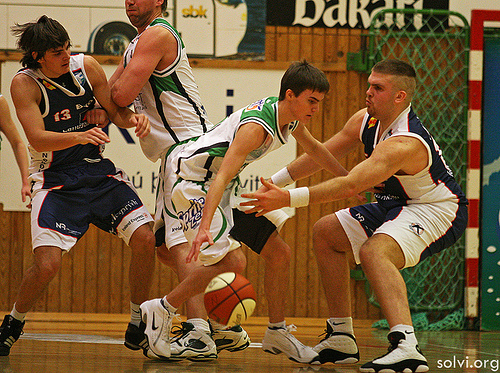

In [124]:
try_image = test_img[0]
Image.open(try_image)

In [125]:
print (predict_captions(try_image))

NameError: name 'final_model' is not defined